**Importing** **Libraries**

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import sympy as sp
import torch
torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=15)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Functions**

In [2]:
### Fast hadamard transform. Recreated from sympy for GPU support
def fwht(seq, inverse):
    n = len(seq)
    if n < 2:
        return a
    if n&(n-1):
        n = 2**n.bit_length()
    a = torch.concat((seq, torch.zeros(n-len(seq)).to(device))) # append zeros to make it power of 2
    h = 2
    while h<=n:
        hf = h // 2
        i = torch.arange(0,n,h).to(device)
        i = i.reshape(len(i), 1)
        j = torch.arange(0, hf, 1).to(device)
        j = j.repeat(len(i),1)
        u, v = a[i+j], a[i+j+hf]
        a[i+j], a[i+j+hf] = u+v, u-v
        h*=2

    if inverse:
        a /= n
    return a

### Uniform quantization
def UQ(flat_grad, B, v, Q_space):
  norm_flat_grad = flat_grad/K
  rand_vect = torch.rand(d).to(device)
  f = torch.bucketize(norm_flat_grad, Q_space)
  q = torch.where(2*B/K/(v-1)*rand_vect<=torch.subtract(norm_flat_grad, Q_space[f-1]), f, f-1)
  return(q)

### Lattice encoding
def LatE(stat, p, num_blocks, w, d_ext):
	stat = torch.concatenate((stat, torch.zeros(int(d_ext-d)).to(device)))
	stat_ext = stat.reshape(int(num_blocks), p)
	coeff = w**torch.arange(p).to(device)
	lamda  = torch.multiply(stat_ext, coeff)
	return(torch.sum(lamda, axis = -1))

### ASK modulation
def ASK(lmbd, r):
	return(-np.sqrt(P)+lmbd*2*np.sqrt(P)/(r-1))

### Minimum-Distance decoding
def MD(y_recvd, delt, r):
	return(torch.round((y_recvd/delt+K*np.sqrt(P)/delt-1/2)))

### Lattice decoding (Successive-Cancelllation)
def LatD(y_hat, b, w, d_):
  if torch.sum(y_hat>= w) == 0 and torch.numel(b) == d_:
    return(b)
  else:
    b = torch.concatenate((b, (y_hat%w).reshape(1,len(y_hat))))
    return(LatD((y_hat-y_hat%w)/w, b, w, d_))


**Main** **code**

In [7]:
cx = 0
d = 64		                                                                    #### dimension
cnt = 0
B_range = [4096] #After lunch: Try till 1000.
MSE1_B = [0]*len(B_range)
MSE4_B = [0]*len(B_range)

for b in B_range:
  Clients = [1000]
  SMSE1_K = [0]*len(Clients)                                                      #### S indicates 'for side info'
  SMSE2_K = [0]*len(Clients)
  SMSE3_K = [0]*len(Clients)
  SMSE4_K = [0]*len(Clients)

  MSE1_K = [0]*len(Clients)
  MSE2_K = [0]*len(Clients)
  MSE3_K = [0]*len(Clients)
  MSE4_K = [0]*len(Clients)
  I = 20		                                                                    #### monte-carlo iterations
  for i in range(len(Clients)):
    K = Clients[i]
    print('Clients: {}, dimension: {}, MC_iter: {}'.format(K, d, I))
    sigma_range =[0.01732]                           #### Sigma range

    SMSE1_K_sig = [0.0]
    SMSE2_K_sig = [0.0]
    SMSE3_K_sig = [0.0]
    SMSE4_K_sig = [0.0]

    MSE1_K_sig = [0.0]
    MSE2_K_sig = [0.0]
    MSE3_K_sig = [0.0]
    MSE4_K_sig = [0.0]

    sig = sigma_range[0]

    SMSE1_K_sig_I = [0.0]*I
    SMSE2_K_sig_I = [0.0]*I
    SMSE3_K_sig_I = [0.0]*I
    SMSE4_K_sig_I = [0.0]*I

    MSE1_K_sig_I = [0.0]*I
    MSE2_K_sig_I = [0.0]*I
    MSE3_K_sig_I = [0.0]*I
    MSE4_K_sig_I = [0.0]*I

    mean = 2*(torch.rand(d).to(device)-0.5)                                   #### True gradients in [-1,1]
    for k in range(I):
      ''' OVER-THE-AIR '''
      snr_range = [180]
      SMSE1_K_sig_I_snr = [0.0]*len(snr_range)
      SMSE2_K_sig_I_snr = [0.0]*len(snr_range)
      SMSE3_K_sig_I_snr = [0.0]*len(snr_range)
      SMSE4_K_sig_I_snr = [0.0]*len(snr_range)

      MSE1_K_sig_I_snr = [0.0]*len(snr_range)
      MSE2_K_sig_I_snr = [0.0]*len(snr_range)
      MSE3_K_sig_I_snr = [0.0]*len(snr_range)
      MSE4_K_sig_I_snr = [0.0]*len(snr_range)


      for l in range(len(snr_range)):
        print('\n Experiment for Iteration = {}, B = {}, SNR = {}dB'.format(k, b, snr_range[l]))
        input_avg = torch.zeros(d).to(device)
        q_input_avg = torch.zeros(d).to(device)
        output_avg = torch.zeros(d).to(device)
        psi_1 = []
        psi_2 = []
        x_e_1 = []
        x_e_2 = []
        dbSNR = snr_range[l]                                                                     #### SNR ratio in dB
        SNR = 10**(dbSNR/10.0)                                                          #### SNR in units/units
        npr = 1.0                                                                     #### Absolute noise power
        P = SNR*npr/K                                                                 #### Absolute signal power allowed per client

        v_1 = int(d)+1                                                          #### No. of quantization levels
        w_1 = v_1*K + 1
        v_2 = int(np.ceil(np.sqrt(np.log(K**1.5)*np.sqrt(96)))*400)                                                  #### Boosting parameter for DAQ
        w_2 = K*v_2+1

        p_1 = min(d, max(1, int(np.log(np.sqrt(2*K*SNR/np.log(K))+1)/np.log(w_1))))                                #### Block size
        p_2 = min(d, max(1, int(np.log(np.sqrt(2*K*SNR/np.log(K))+1)/np.log(w_2))))

        num_blocks_1 = int(np.ceil(d/p_1))
        num_blocks_2 = int(np.ceil(d/p_2))

        d_ext_1 = num_blocks_1*p_1
        d_ext_2 = num_blocks_2*p_2
        M = b/K*int(np.ceil(np.sqrt(np.log(K**1.5))))                						    #### The high probability region [-M, M] used for correlated sampling in DAQ


        print('\nFor side info: v_1= {}, w_1= {}, num_Blocks_1 = {}, blocksize_1 = {}'.format(v_1, w_1, num_blocks_1, p_1))
        print('For DAQ: v_2= {}, w_2= {}, num_Blocks_2 = {}, blocksize_2 = {}'.format(v_2, w_2, num_blocks_2, p_2))

        r_1 = (w_1**p_1-1)/K + 1                                                #### Number of ASK codewords in first transmission
        del_1 = 2*np.sqrt(P)/(r_1-1)

        r_2 = (w_2**p_2-1)/K + 1                                                #### Number of ASK codewords in second transmission
        del_2 = 2*np.sqrt(P)/(r_2-1)

        U_shared = 2*M*(torch.rand(K, v_2, d).to(device)-0.5)                   #### clients in C_2 x Boosting x dimensions. U~[-M,M] iid I times
        diagonal = 2*torch.randint(0,2,(d,)).to(device)-torch.ones(d).to(device)#### Random signs. Same for each client
        for client in range(2*K):
          t = 6*sig*(torch.rand(d).to(device)-0.5)                              #### Noise in [-3\sigma, +3\sigma].
          x = mean + t                                                          #### Noisy gradient in [-1-3sigma, 1+3sigma]
          B = b*np.sqrt(d)                                                       #### Maximum norm of noisy grad                                                                     #### E[x] = mean; var(x) = var(t) = 3sig^2 = sig_paper^2/d; norm(x) <= B^2 = B_paper^2 = d(1+3sig)^2

          if (client<K):
            ''' PERFORM UNIFORM QUANTIZATION '''

            Q_space = -B/K + torch.arange(v_1).to(device)*2*B/K/(v_1-1)               #### Quantization points in [-B/K,B/K]
            x_uq = UQ(x, B, v_1, Q_space)
            q_input_avg = q_input_avg - B/K + 2*B*x_uq/K/(v_1-1)

            ''' LATTICE ENCODING '''
            x_uq_lenc = LatE(x_uq, p_1, num_blocks_1, w_1, d_ext_1)
            ''' ASK MODULATION '''
            x_uq_lenc_ask  = ASK(x_uq_lenc, r_1)
            #print('ASK codeword', x_ask)
            psi_1.append(x_uq_lenc_ask)
            x_e_1.append(x_uq)
            #print('Done for client', client)

          else:
            input_avg = x + input_avg
            ''' PERFORM DAQ '''
            sgn_x = torch.multiply(x/K, diagonal)
            rot_x = fwht(sgn_x, False)/(d**0.5)
            x_rdaq = sum(torch.where((U_shared[client-K]<= rot_x), 1, 0))       #### Sum after different boosting iterations.
            x_rdaq_lenc = LatE(x_rdaq, p_2, num_blocks_2, w_2, d_ext_2)
            x_rdaq_lenc_ask = ASK(x_rdaq_lenc, r_2)
            psi_2.append(x_rdaq_lenc_ask)
            x_e_2.append(x_rdaq)


        ''' First MAC transmission '''
        y_1 = sum(psi_1)+ np.sqrt(npr)*torch.randn(num_blocks_1).to(device)     #### Adding awgn noise
        #print('Sum of ASK enc:', sum(psi))
        #print('Channel output', y)
        #print(y)
        x_1_hat = MD(y_1, del_1, r_1)                                           #### Min-distance Decoding
        #print('sum of ASK dec', -K*np.sqrt(P)+x_hat*2*np.sqrt(P)/(r-1))
        #print('Index decoded', x_hat)
        x_1_hat_ldec = LatD(x_1_hat, torch.Tensor([]).to(device), w_1, d_ext_1) #### Lattice Decoding
        x_1_hat_ldec = x_1_hat_ldec.transpose(0, 1).flatten()
        #print('Sum of UQ enc', sum(x_e_1))
        #print('Sum of UQ dec', x_1_hat_ldec)
        x_1_hat_ldec_uq = -B + x_1_hat_ldec[:d]*2*B/K/(v_1-1)                   #### Mean estimate of gradients in C_1 group


        ''' Preparing the side information: rotation and 1-bit quantization '''
        norm_side_info = x_1_hat_ldec_uq/K
        sgn_norm_side_info = torch.multiply(norm_side_info, diagonal)
        rot_sgn_norm_side_info = fwht(norm_side_info, False)/(d**0.5)
        ss = (torch.abs(rot_sgn_norm_side_info)<=M)*rot_sgn_norm_side_info
        q_rot_sgn_norm_side_info = torch.where(U_shared<=ss, 1, 0)
        ind_1 = sum(torch.sum(q_rot_sgn_norm_side_info, axis = 1))
        print('\nSide information constructed!')
        ''' Second MAC transmission '''
        y_2 = sum(psi_2) + np.sqrt(npr)*torch.randn(num_blocks_2).to(device)
        x_2_hat = MD(y_2, del_2, r_2)                                           #### Decoded sum of ASK codeword
        x_2_hat_ldec = LatD(x_2_hat, torch.Tensor([]).to(device), w_2, d_ext_2) #### Decoded sum of lattice coefficients
        x_2_hat_ldec = x_2_hat_ldec.transpose(0, 1).flatten()
        #print('Sum of DAQ enc', sum(x_e_2))
        #print('Sum of DAQ dec', x_2_hat_ldec)
        ind_2 = x_2_hat_ldec
        output = 2*M/v_2*torch.multiply(diagonal, fwht((d**0.5)*(ind_2[:d] - ind_1[:d]),True)) + x_1_hat_ldec_uq
        #print((2*M/v_2*torch.multiply(diagonal, fwht((d**0.5)*(ind_2[:d] - ind_1[:d]),True))).norm())
        #print(ind_1)
        #print(ind_2[:d])


        total_num_blocks = num_blocks_1 + num_blocks_2
        print('WZ estimation done! Total channel uses = ', total_num_blocks)
        print()
        MSE_1 = output - mean                                                   #### MSE w.r.t true grad (over MAC)
        MSE_2 = output - input_avg/K                                            #### MSE w.r.t avg. of noisy grad (over MAC)
        MSE_3 = input_avg/K - mean                                              #### MSE w.r.t empirical mean (Benchmark, noiseless channel)
        MSE_4 = q_input_avg - mean                                              #### MSE w.r.t avg. of quant. noisy grad (noiseless channel)

        SMSE_1 = x_1_hat_ldec_uq - mean                                                   #### MSE w.r.t true grad (over MAC)
        SMSE_2 = x_1_hat_ldec_uq - input_avg/K                                            #### MSE w.r.t avg. of noisy grad (over MAC)
        SMSE_3 = input_avg/K - mean                                              #### MSE w.r.t empirical mean (Benchmark, noiseless channel)
        SMSE_4 = q_input_avg - mean                                              #### MSE w.r.t avg. of quant. noisy grad (noiseless channel)

        print('TM:', mean.norm(), 'QEM:', q_input_avg.norm(), 'WZ:', output.norm(), 'UQ:', x_1_hat_ldec_uq.norm())
        print('WZ Error:', MSE_1.norm()*np.sqrt(total_num_blocks), 'UQ Error', SMSE_1.norm()*np.sqrt(total_num_blocks))

        MSE1_K_sig_I_snr[l] = MSE_1.norm()*np.sqrt(total_num_blocks)
        MSE2_K_sig_I_snr[l] = MSE_2.norm()*np.sqrt(total_num_blocks)
        MSE3_K_sig_I_snr[l] = MSE_3.norm()*np.sqrt(total_num_blocks)
        MSE4_K_sig_I_snr[l] = MSE_4.norm()*np.sqrt(total_num_blocks)

        SMSE1_K_sig_I_snr[l] = SMSE_1.norm()*np.sqrt(num_blocks_1)
        SMSE2_K_sig_I_snr[l] = SMSE_2.norm()*np.sqrt(num_blocks_1)
        SMSE3_K_sig_I_snr[l] = SMSE_3.norm()*np.sqrt(num_blocks_1)
        SMSE4_K_sig_I_snr[l] = SMSE_4.norm()*np.sqrt(num_blocks_1)

      MSE1_K_sig_I[k] = MSE1_K_sig_I_snr
      MSE2_K_sig_I[k] = MSE2_K_sig_I_snr
      MSE3_K_sig_I[k] = MSE3_K_sig_I_snr
      MSE4_K_sig_I[k] = MSE4_K_sig_I_snr

      SMSE1_K_sig_I[k] = SMSE1_K_sig_I_snr
      SMSE2_K_sig_I[k] = SMSE2_K_sig_I_snr
      SMSE3_K_sig_I[k] = SMSE3_K_sig_I_snr
      SMSE4_K_sig_I[k] = SMSE4_K_sig_I_snr

    #print(MSE1_K_sig_I)
    MSE1_K_sig = np.array(sum(torch.Tensor(MSE1_K_sig_I)).to('cpu')/I)
    MSE2_K_sig = np.array(sum(torch.Tensor(MSE2_K_sig_I)).to('cpu')/I)
    MSE3_K_sig = np.array(sum(torch.Tensor(MSE3_K_sig_I)).to('cpu')/I)
    MSE4_K_sig = np.array(sum(torch.Tensor(MSE4_K_sig_I)).to('cpu')/I)

    print('Average WZ Error after {} iterations: {}'.format(I, MSE1_K_sig))

    SMSE1_K_sig = np.array(sum(torch.Tensor(SMSE1_K_sig_I)).to('cpu')/I)
    SMSE2_K_sig = np.array(sum(torch.Tensor(SMSE2_K_sig_I)).to('cpu')/I)
    SMSE3_K_sig = np.array(sum(torch.Tensor(SMSE3_K_sig_I)).to('cpu')/I)
    SMSE4_K_sig = np.array(sum(torch.Tensor(SMSE4_K_sig_I)).to('cpu')/I)

    MSE1_K[i] = MSE1_K_sig
    MSE2_K[i] = MSE2_K_sig
    MSE3_K[i] = MSE3_K_sig
    MSE4_K[i] = MSE4_K_sig

    SMSE1_K[i] = SMSE1_K_sig
    SMSE2_K[i] = SMSE2_K_sig
    SMSE3_K[i] = SMSE3_K_sig
    SMSE4_K[i] = SMSE4_K_sig

  MSE1_B[cnt] = MSE1_K
  MSE4_B[cnt] = MSE4_K
  cnt+=1

#np.savetxt("RMSE_CUQ_v_"+str(v)+"_"+str(d)+".dat", MSE_CUQ, delimiter =", ", fmt ='% s')

Clients: 1000, dimension: 64, MC_iter: 20

 Experiment for Iteration = 0, B = 4096, SNR = 180dB

For side info: v_1= 65, w_1= 65001, num_Blocks_1 = 32, blocksize_1 = 2
For DAQ: v_2= 4400, w_2= 4400001, num_Blocks_2 = 64, blocksize_2 = 1

Side information constructed!
WZ estimation done! Total channel uses =  96

TM: tensor(4.797192002458750, device='cuda:0') QEM: tensor(8.192000000000007, device='cuda:0') WZ: tensor(13.730496960215733, device='cuda:0') UQ: tensor(9.043723127110997, device='cuda:0')
WZ Error: tensor(106.498590112912623, device='cuda:0') UQ Error tensor(75.538653134862329, device='cuda:0')

 Experiment for Iteration = 1, B = 4096, SNR = 180dB

For side info: v_1= 65, w_1= 65001, num_Blocks_1 = 32, blocksize_1 = 2
For DAQ: v_2= 4400, w_2= 4400001, num_Blocks_2 = 64, blocksize_2 = 1

Side information constructed!
WZ estimation done! Total channel uses =  96

TM: tensor(4.797192002458750, device='cuda:0') QEM: tensor(7.594187250785966, device='cuda:0') WZ: tensor(16.5206591

**Plotting**

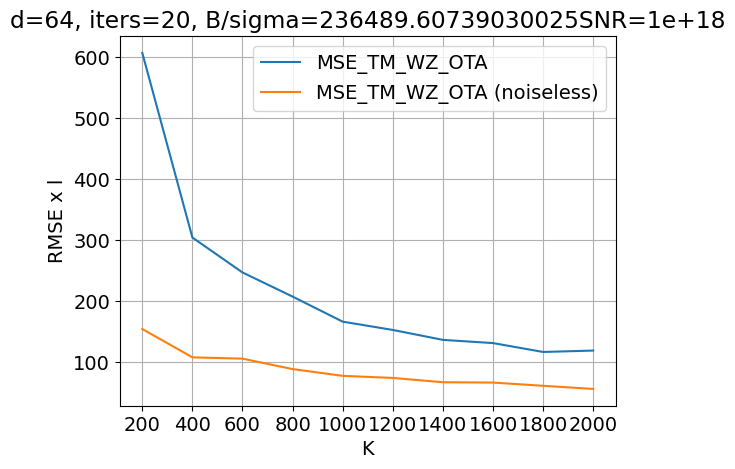

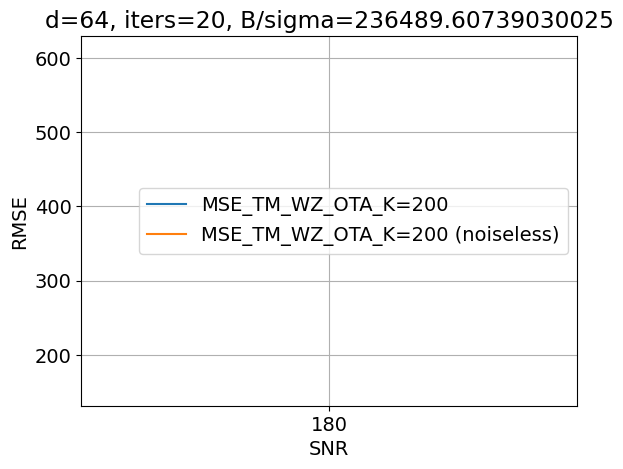

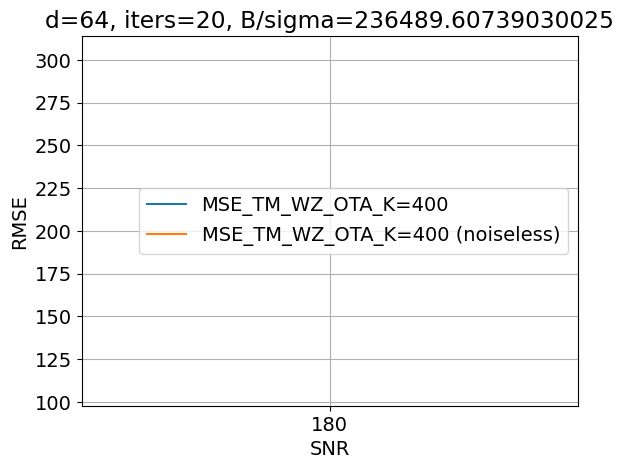

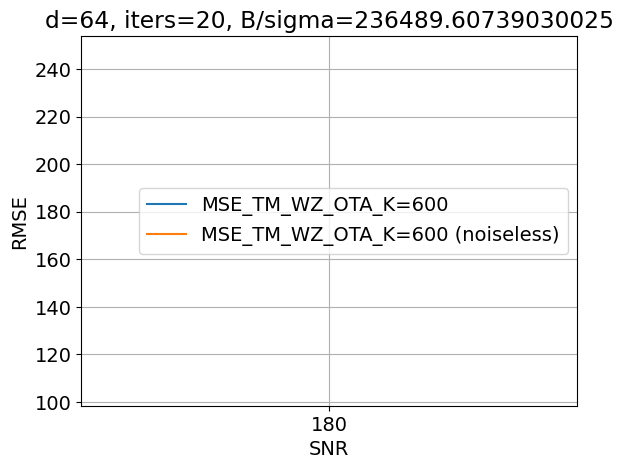

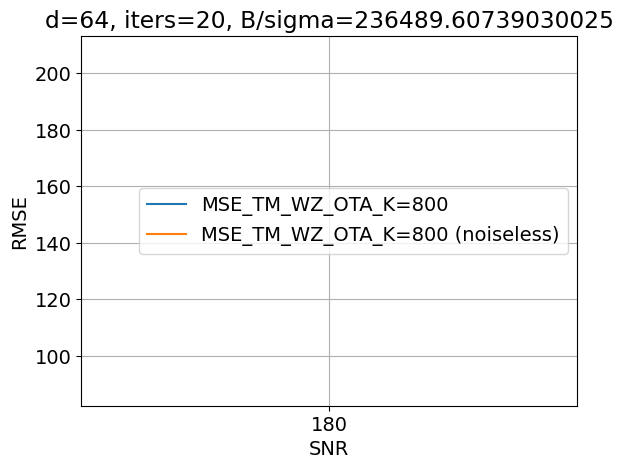

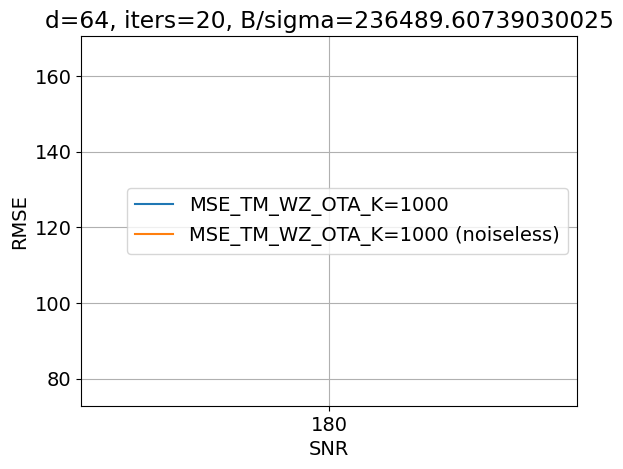

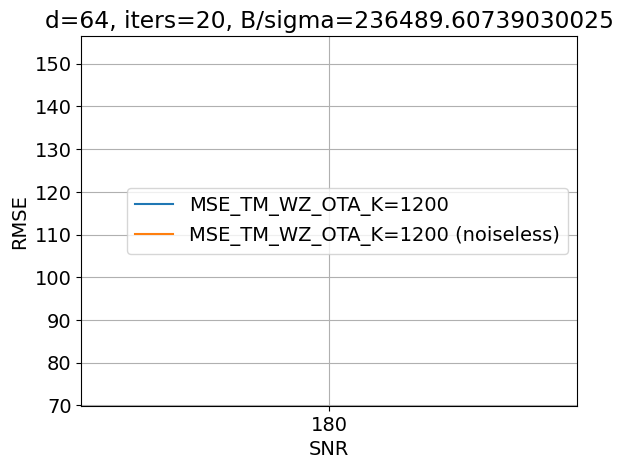

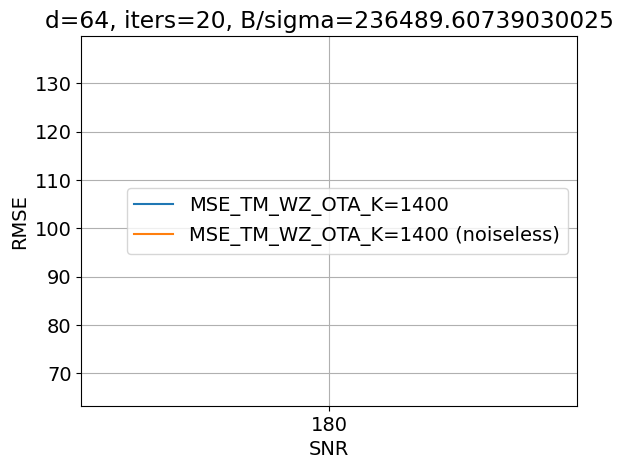

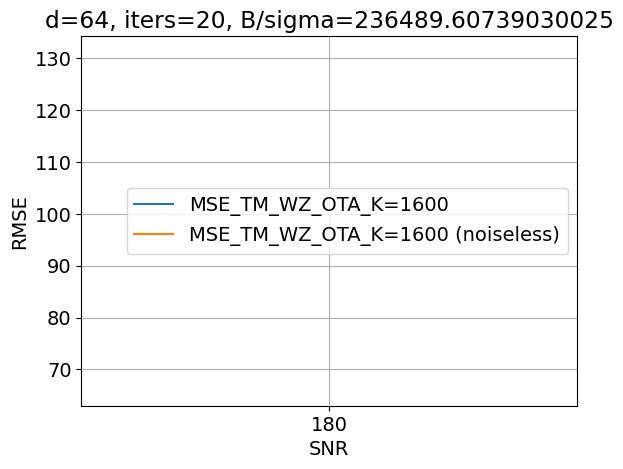

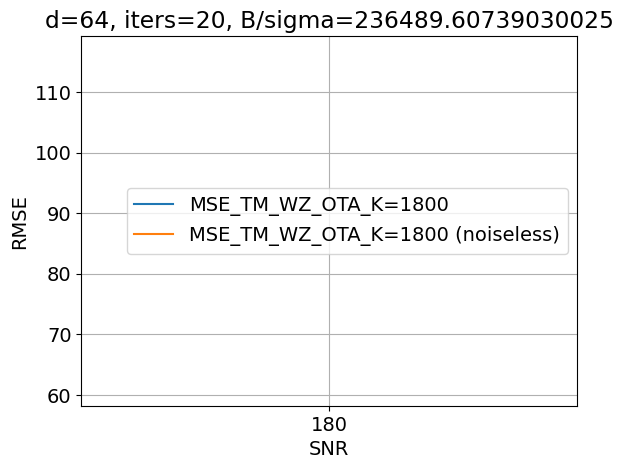

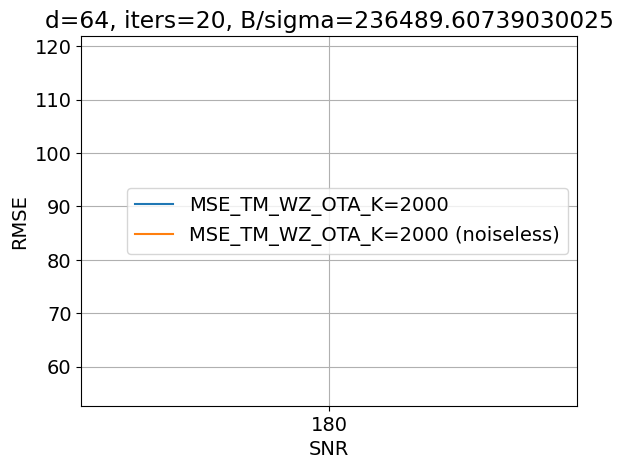

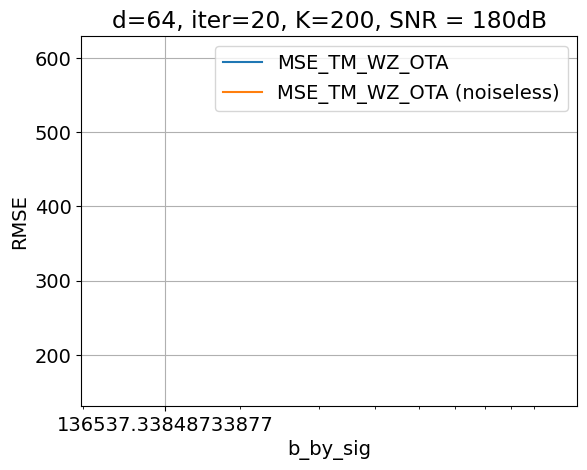

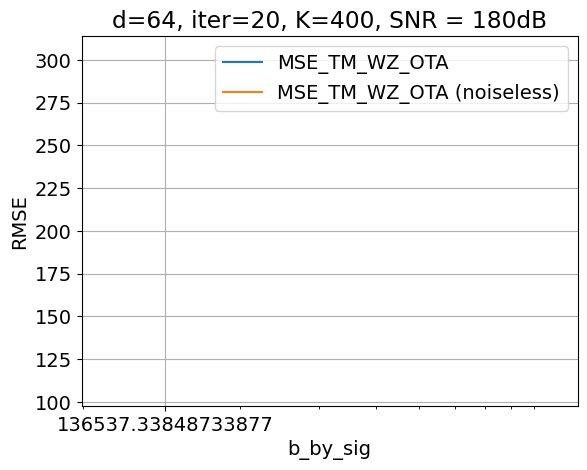

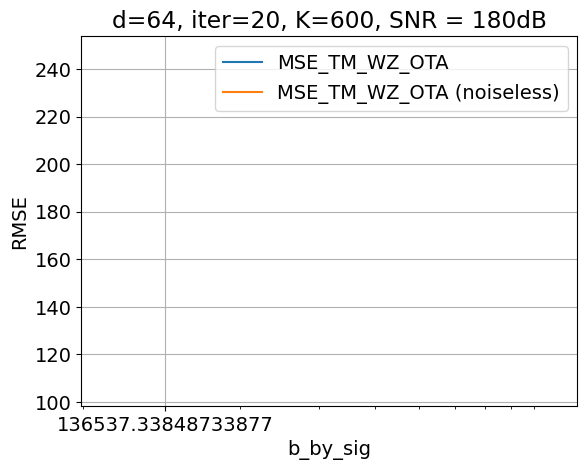

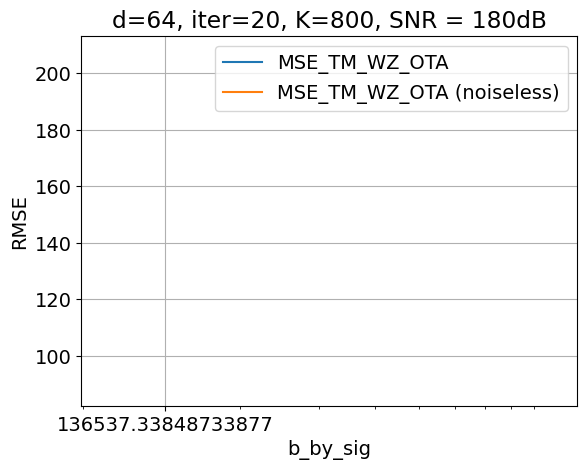

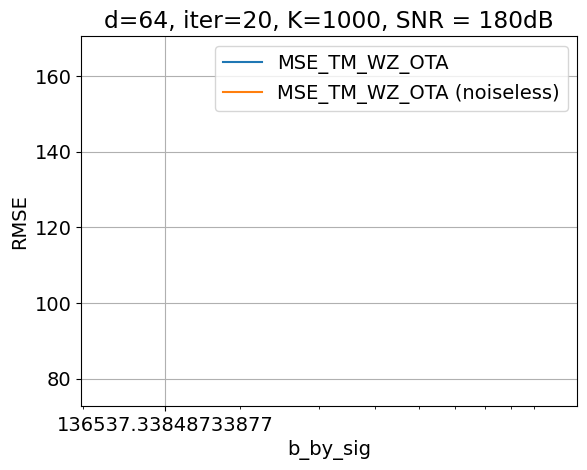

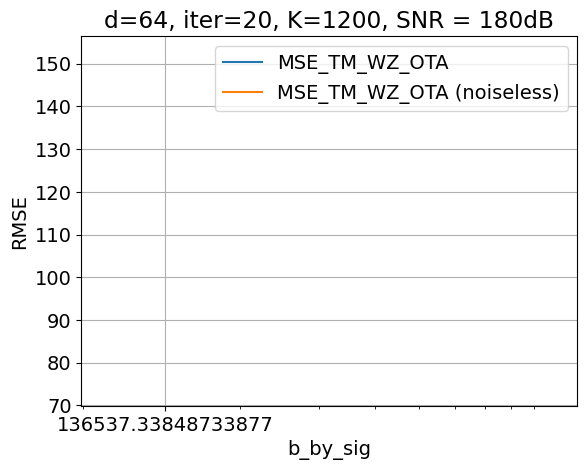

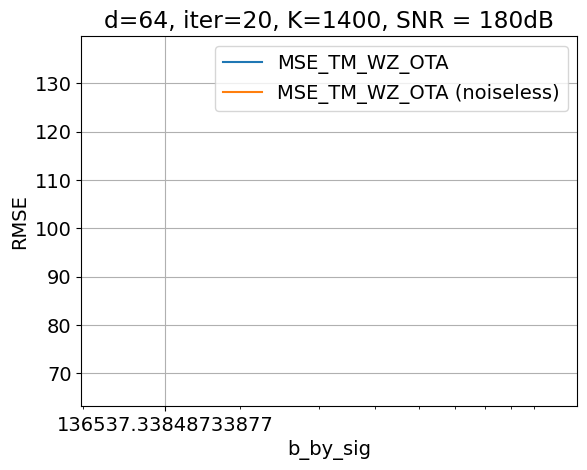

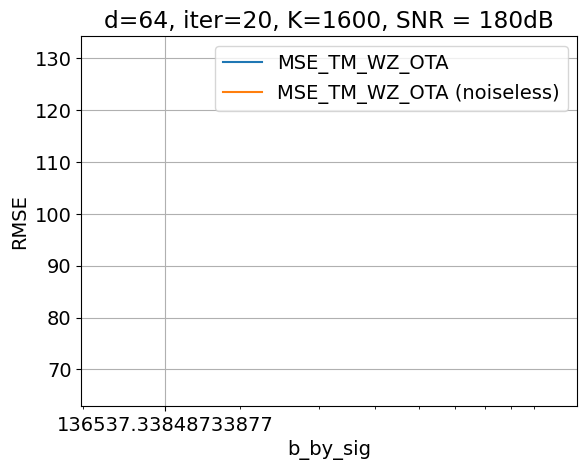

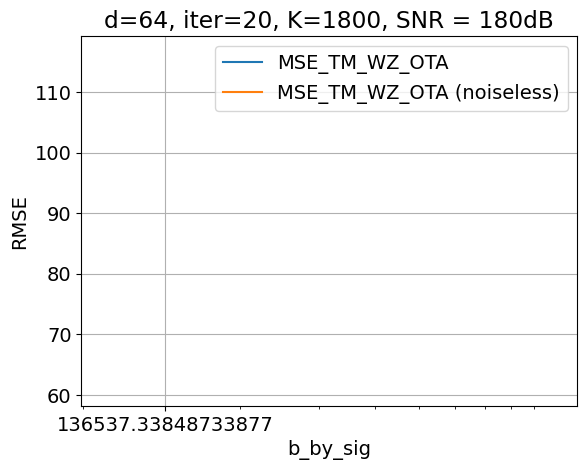

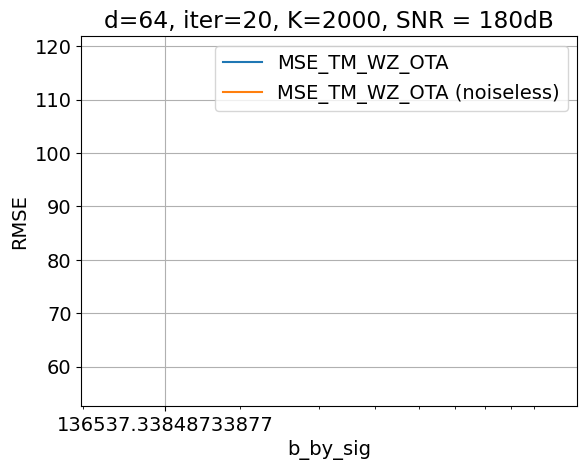

In [4]:
pts = 14 ## Number of points for plotting. Maximum = len(sigma_range)
font = {'weight': 'normal', 'size': 14}
matplotlib.rc('font', **font)

Tot_clnts = [i*2 for i in Clients]
for b in range(len(B_range)):
  B1 = B_range[b]
  plt.plot(Tot_clnts[:pts], MSE1_B[b][:pts], label='MSE_TM_WZ_OTA')
  #plt.plot(Tot_clnts[:pts], MSE2_K[i][j][:pts], label='MSE_EM_WZ_OTA_K='+str(K)+' SNR='+str(snr_range[j])+' sigma='+str(sigma_range[j]))
  #plt.plot(Tot_clnts[:pts], MSE3_K[i][j][:pts], label='MSE_TM_EM_K='+str(K)+' (noiseless)'+' sigma='+str(sigma_range[j]))
  plt.plot(Tot_clnts[:pts], MSE4_B[b][:pts], label='MSE_TM_WZ_OTA (noiseless)')

    #plt.plot(snr_range[:pts], SMSE1_K[i][j][:pts], label='MSE_TM_UQ_OTA_K='+str(2*K))
    #plt.plot(sigma_range[:pts], MSE2_K[i][j][:pts], label='MSE_EM_CUQ_K='+str(K)+' SNR='+str(snr_range[j])+' sigma='+str(sigma_range[j]))
    #plt.plot(sigma_range[:pts], MSE3_K[i][j][:pts], label='MSE_TM_EM_K='+str(K)+' (noiseless)'+' sigma='+str(sigma_range[j]))
    #plt.plot(snr_range[:pts], SMSE4_K[i][j][:pts], label='MSE_TM_UQ_OTA_K='+str(2*K)+' (noiseless)')


  plt.legend()
  plt.xlabel('K')
  plt.ylabel('RMSE x l')
  #plt.xscale('log')
  #plt.yscale('log')
  plt.xticks(ticks= Tot_clnts[:pts], labels = Tot_clnts[:pts])
  plt.title('d='+str(d)+', iters='+str(I)+', B/sigma='+str(B1/sig)+'SNR='+str(SNR))
  plt.grid()
  plt.show()


for b in range(len(B_range)):
  B1 = B_range[b]
  for i in range(len(Clients)):
    K = Clients[i]
    plt.plot(snr_range[:pts], MSE1_B[b][i][:pts], label='MSE_TM_WZ_OTA_K='+str(2*K))
    #plt.plot(sigma_range[:pts], MSE2_K[i][j][:pts], label='MSE_EM_WZ_OTA_K='+str(K)+' SNR='+str(snr_range[j])+' sigma='+str(sigma_range[j]))
    #plt.plot(sigma_range[:pts], MSE3_K[i][j][:pts], label='MSE_TM_EM_K='+str(K)+' (noiseless)'+' sigma='+str(sigma_range[j]))
    plt.plot(snr_range[:pts], MSE4_B[b][i][:pts], label='MSE_TM_WZ_OTA_K='+str(2*K)+' (noiseless)')

    #plt.plot(snr_range[:pts], SMSE1_K[i][j][:pts], label='MSE_TM_UQ_OTA_K='+str(2*K))
    #plt.plot(sigma_range[:pts], MSE2_K[i][j][:pts], label='MSE_EM_CUQ_K='+str(K)+' SNR='+str(snr_range[j])+' sigma='+str(sigma_range[j]))
    #plt.plot(sigma_range[:pts], MSE3_K[i][j][:pts], label='MSE_TM_EM_K='+str(K)+' (noiseless)'+' sigma='+str(sigma_range[j]))
    #plt.plot(snr_range[:pts], SMSE4_K[i][j][:pts], label='MSE_TM_UQ_OTA_K='+str(2*K)+' (noiseless)')


    plt.legend()
    plt.xlabel('SNR')
    plt.ylabel('RMSE')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xticks(ticks= snr_range[:pts], labels=snr_range[:pts])
    plt.title('d='+str(d)+', iters='+str(I)+', B/sigma='+str(B1/sig))
    plt.grid()
    plt.show()


b_by_sig = [B_range[b]/np.sqrt(3)/sig for b in range(len(B_range))]

MSE1_modified = np.array(MSE1_B).transpose()
#MSE2_modified = np.array(MSE2_K[i]).transpose()
#MSE3_modified = np.array(MSE3_K[i]).transpose()
MSE4_modified = np.array(MSE4_B).transpose()

for i in range(len(Clients)):
  K = Clients[i]

  for k in range(len(snr_range)):
    plt.plot(b_by_sig[:pts], MSE1_modified[k][i][:pts], label='MSE_TM_WZ_OTA')
    #plt.plot(sigma_range[:pts], MSE2_modified[k][:pts], label='MSE_EM_CUQ_K='+' SNR='+str(snr_range[k]))
    #plt.plot(sigma_range[:pts], MSE3_modified[k][:pts], label='MSE_TM_EM_K='+' (noiseless)'+' SNR='+str(snr_range[k]))
    plt.plot(b_by_sig[:pts], MSE4_modified[k][i][:pts], label='MSE_TM_WZ_OTA'+' (noiseless)')

    #plt.plot(sigma_range[:pts], SMSE1_modified[k][:pts], label='MSE_TM_UQ_OTA')
    #plt.plot(sigma_range[:pts], SMSE2_modified[k][:pts], label='MSE_EM_CUQ_K='+' SNR='+str(snr_range[k]))
    #plt.plot(sigma_range[:pts], SMSE3_modified[k][:pts], label='MSE_TM_EM_K='+' (noiseless)'+' SNR='+str(snr_range[k]))
    #plt.plot(sigma_range[:pts], SMSE4_modified[k][:pts], label='MSE_TM_UQ_OTA'+' (noiseless)')

    plt.legend()
    plt.xlabel('b_by_sig')
    plt.ylabel('RMSE')
    plt.xscale('log')
    #plt.yscale('log')
    plt.xticks(ticks= b_by_sig[:pts], labels=b_by_sig[:pts])
    plt.title('d='+str(d)+', iter='+str(I)+', K='+str(2*K)+', SNR = '+str(snr_range[k])+'dB')
    plt.grid()
    plt.show()


In [5]:
import sympy as sp

a = [-0.2, 2.4, 1.2, -0.9, -0.2, 2.4, 1.2, -0.9]
di= 2*np.random.randint(0,2,len(a))-1
print(sp.fwht(a), torch.Tensor(a).norm())
print(di)
hd = fwht(torch.Tensor(a).to(device)*torch.Tensor(di).to(device), False)/8**0.5
print(hd, hd.norm())

print(torch.multiply(torch.Tensor(di).to(device), fwht(hd*8**0.5, True)))
print(2*M*200)

[5.00000000000000, -1.00000000000000, 3.80000000000000, -9.40000000000000, 0, 0, 0, 0] tensor(4.012480529547776)
[ 1  1 -1  1 -1  1  1 -1]
tensor([ 1.697056274847714, -1.697056274847714,  1.697056274847714,
        -1.697056274847714, -1.626345596729059, -0.353553390593274,
         1.343502884254440,  0.070710678118654], device='cuda:0') tensor(4.012480529547775, device='cuda:0')
tensor([-0.200000000000000,  2.400000000000000,  1.200000000000000,
        -0.900000000000000, -0.200000000000000,  2.400000000000000,
         1.200000000000000, -0.900000000000000], device='cuda:0')
6553.6


In [8]:
print(MSE1_B)
print(MSE4_B)

[[array([124.4881912])]]
[[array([56.98469881])]]
